<a href="https://colab.research.google.com/github/uribo1008/azure-openai-test/blob/main/B4_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. テキストデータの収集

### 1-1. 【授業中は実行しません】　スクレイピング

**すごく時間がかかるので授業中はここを実行せず取得済みのテキストデータを利用します！！**

ここではYahoo!知恵袋からQ&Aのテキストデータをスクレイピングで取得します。
以下のように実行すると指定されたカテゴリの質問と回答のテキストをスクレイピングします。

```
text = get_yahoo_chiebukuro_text(カテゴリ)
```

「カテゴリ」としては以下のようなものを登録しています。
- 恋愛相談
- 大学受験
- 住宅

Yahoo!知恵袋のカテゴリIDが分かれば

なお，過剰な負荷を避けるために以下のような配慮をしています。
- 一度に取得する回答の数は最大60？（10ページ分）
- １ページ分の回答をスクレイピングするたびにほんの少し休みます。

**↓うっかりクリックして実行しないように！！！**

In [ ]:
# 必要なパッケージの読み込み
import requests
import re
import time
import random
from bs4 import BeautifulSoup

MAIN_SORT_KEY = {"更新日時の新しい順":16, "更新日時の古い順": 17, "質問日時の新しい順":20, "質問日時の古い順":21, "回答数の多い順":4, "回答数の少ない順":5, "お礼の多い順":8}
DETAIL_SORT_KEY={"ナイスの多い順":0, "新しい順":1, "古い順":2}
QA_STAT = {"回答受付中": 0, "解決済み": 1, "全て": 3}

def get_qa_text(base_link, sort_mode="ナイスの多い順"):
  text_list = []
  sort_id = DETAIL_SORT_KEY[sort_mode]
  link = base_link + "?sort={}".format(sort_id)

  res = requests.get(link)
  soup = BeautifulSoup(res.text.encode(res.encoding), "html.parser")

  ans_count_tag = soup.select_one('strong[class*="Chie-QuestionItem__AnswerNumber__"]')
  ans_count = int("".join(ans_count_tag.text.split(","))) if ans_count_tag is not None else 0
  max_page = min(10, (ans_count // 10 + 1) if 0 < ans_count else 1)

  print(f"*** QA: # of answers:{ans_count}, pages:{max_page} ... ")

  print("**** extracting Question ... ", end = "")
  #que_text_tag = soup.select_one('div[class*="Chie-QuestionItem__Text__"]')
  que_text_tag = soup.find("div", class_=re.compile(r"Chie-QuestionItem__Text__"))
  if que_text_tag is not None:
    text_list.append(que_text_tag.text)
  print("done.")

  for page_num in range(1, max_page+1):
    print(f"**** extracting Answers in page {page_num} ... ", end="")
    page_link = link + "&page={}".format(page_num)

    # 過剰な負荷を避けるため，１ページ分の記事を取得する前に 1〜3秒休む
    time.sleep(random.randrange(1, 3))

    res = requests.get(link)
    soup = BeautifulSoup(res.text.encode(res.encoding), "html.parser")

    # ans_text_list = soup.select('div[class*="Chie-AnswerItem__ItemText__"]')
    ans_text_list = soup.find_all("div", class_=re.compile(r"Chie-AnswerItem__ItemText__"))
    ans_text_num = 0
    for ans_tag in ans_text_list:
      text_list.append(ans_tag.text)
      ans_text_num += 1
    print(f"{ans_text_num} answers extracted.")

  return "".join(text_list)


def get_qa_link_list(url):
  qa_link_list = []

  # 過剰な負荷を避けるため，１ページ分のリンクリストを取得する前に 1〜3秒休む
  time.sleep(random.randrange(1, 3))

  res = requests.get(url)
  soup = BeautifulSoup(res.text.encode(res.encoding), "html.parser")
  qa_list = soup.find("div", {"id": "qa_lst"})
  qa_atag_list = qa_list.find_all("a")
  for qa_atag in qa_atag_list:
    qa_link_list.append(qa_atag["href"])
  return qa_link_list


def get_yahoo_chiebukuro_text(category_id, sort_mode="回答数の多い順", qa_stat="解決済み", max_qa_num = 10, page_count=1):
  base_url = "https://chiebukuro.yahoo.co.jp/category/{}/question/list?flg={}&sort={}&page={}"
  sort_id = MAIN_SORT_KEY[sort_mode]
  qa_stat_id = QA_STAT[qa_stat]

  print("* launching the process ... ")
  qa_link_list = []
  for page in range(1, page_count+1):
    print(f"** retrieving QA links from page #{page} ... ", end = "")
    url = base_url.format(category_id, qa_stat_id, sort_id, page)
    qa_link_list_sub = get_qa_link_list(url)
    qa_link_list.extend(qa_link_list_sub)
    print(f"{len(qa_link_list_sub)} links retrieved.")
    if max_qa_num < len(qa_link_list):
      break

  # 指定された個数までのQ&Aしか取得しない（デフォルトでは10）
  qa_link_list = qa_link_list[:max_qa_num]

  text_list = []
  for qa_link in qa_link_list:
    print(f"** retrieving QA from {qa_link} ... ")
    text_list.append(get_qa_text(qa_link))
    print("** retrieving QA done.")
  print("* done.")

  return "".join(text_list)

In [ ]:
# 誤って実行しないようにコメントアウトしています。実行したい場合は行頭の # を取り除いてください。
# CATEGORY = {"恋愛相談": 2078675272, "大学受験": 2079405665, "住宅": 2078297940, "話題の人物":2078297579}
# text = get_yahoo_chiebukuro_text(CATEGORY["話題の人物"])
#調べるときはYAHOO知恵袋のカテゴリから選択した落ちにURLに含まれている数字を持ってい来る必要がある。

### 1-1. 【授業中はこちらを実行】 テキストデータのアップロード

テキストデータをスクレイピングで取得する代わりに，取得済みのテキストデータをアップロードして利用します。

先週の資料に従って，BEEF+からテキストデータをダウンロードし，Google Colaboratoryのセッションストレージにアップロードしてください。

In [56]:
# 以下では大学受験の記事（yc_univ_2018.txt)を利用
with open("yc_univ_2018.txt", "r") as f:
  text = f.read()

### 1-2. テキストの確認

取得した（または読み込んだ）テキストデータを確認します。


In [57]:
text

"\t\t\t\t\t\t\t\t\t\t高3女子です\n中学の成績は学年200人中トップで、（中学と高校のレベルは違うとわかっています）偏差値も70くらいはありました\n高校に入ってからは、3年になるまで遊びと部活に明け暮れ、模試でもひどい成績を取り続けました\n．\n3年生になってから塾に通うようになり、明確に目標ができたことにより進研模試の合計点は2ヶ月で120点あがりました（9教科）\nしかし偏差値はだいたい50ととても低いです\nこんなに行きたいと思った大学は他にはなくて、家庭の事情もあり早稲田に落ちたら公務員として就職しようと思っています\nこれからの8ヶ月間死に物狂いで努力したら合格できるでしょうか、？\n前の質問でそんなことを聞くのは他力本願だと言われ、自覚はしていますが、モチベーションがほしいのでよろしくお願いします！\n\t\t\t\t\t過去問を見てください。8ヵ月で合格レベルに達する計画が立てられれば、後は実行するだけです。闇雲に頑張っても合格はできません。\n\n偏差値70の高校でも下位層の人達は地方国公立大や中堅私大止まりの人が多いです。中学時代、楽勝で偏差値70が取れてた科目は大学受験でも通用する可能性が高いですが、必死にやって偏差値70だった科目は大学受験では偏差値60にもならない場合が多いです。まず、中学で200人中１番、よくそれにプライド持っている人いますが、中学校のレベル差で随分違うのでそれで伸びしろは推測できません。\n２ヶ月で120点アップしても進研模試で偏差値50なら、高くはないのはわかりますよね？周りも同じように勉強しているわけです。\nでは早稲田合格はできるか？\n私はダメだとは思いません。ビリギャルはそこそこの進学校にいて、それなりに勉強することを知っていたから伸びました。質問者の方も遠からずだと思います。\nですから、ビリギャル並みに学校のいらない科目はすべて捨てて、私立文系対策に絞って勉強すべきです。追試で単位が取れるなら、理系科目、要らない社会の科目も捨てまくり、ひたすら英語を中心として私立大文系対策をすれば可能性はあると思います。\n次の模試、といっても進研模試ではなく、受験生が参考にする模試があると思うのですが、その模試で英国社が60まできていたら、可能性も見えてくるかも。\n実際、２年生までは地を這うよう

## 2. クレンジング

テキストデータに含まれる不要なデータを取り除きます。

上記で確認したように，今回のテキストデータはスクレイピングの際にHTMLタグなどは除去しているので，あまり不要なデータがありません。

今回は改行コードやタブ文字などの余分な空白文字を取り除くという処理だけ行います。場合によってはアルファベットの大文字小文字や全角半角の変換も必要かもしれません。

### 2-1. クレンジング用の関数定義

In [58]:
import re

# クレンジング用の関数定義
def cleansing(text):
  clean_text = re.sub("\s", "", text)  # 余分な空白の除去
  return clean_text

### 2-2. クレンジングの実行

In [59]:
clean_text = cleansing(text)

### 2-3. テキストの確認

クレンジング後のテキストを確認します

In [60]:
clean_text

"高3女子です中学の成績は学年200人中トップで、（中学と高校のレベルは違うとわかっています）偏差値も70くらいはありました高校に入ってからは、3年になるまで遊びと部活に明け暮れ、模試でもひどい成績を取り続けました．3年生になってから塾に通うようになり、明確に目標ができたことにより進研模試の合計点は2ヶ月で120点あがりました（9教科）しかし偏差値はだいたい50ととても低いですこんなに行きたいと思った大学は他にはなくて、家庭の事情もあり早稲田に落ちたら公務員として就職しようと思っていますこれからの8ヶ月間死に物狂いで努力したら合格できるでしょうか、？前の質問でそんなことを聞くのは他力本願だと言われ、自覚はしていますが、モチベーションがほしいのでよろしくお願いします！過去問を見てください。8ヵ月で合格レベルに達する計画が立てられれば、後は実行するだけです。闇雲に頑張っても合格はできません。偏差値70の高校でも下位層の人達は地方国公立大や中堅私大止まりの人が多いです。中学時代、楽勝で偏差値70が取れてた科目は大学受験でも通用する可能性が高いですが、必死にやって偏差値70だった科目は大学受験では偏差値60にもならない場合が多いです。まず、中学で200人中１番、よくそれにプライド持っている人いますが、中学校のレベル差で随分違うのでそれで伸びしろは推測できません。２ヶ月で120点アップしても進研模試で偏差値50なら、高くはないのはわかりますよね？周りも同じように勉強しているわけです。では早稲田合格はできるか？私はダメだとは思いません。ビリギャルはそこそこの進学校にいて、それなりに勉強することを知っていたから伸びました。質問者の方も遠からずだと思います。ですから、ビリギャル並みに学校のいらない科目はすべて捨てて、私立文系対策に絞って勉強すべきです。追試で単位が取れるなら、理系科目、要らない社会の科目も捨てまくり、ひたすら英語を中心として私立大文系対策をすれば可能性はあると思います。次の模試、といっても進研模試ではなく、受験生が参考にする模試があると思うのですが、その模試で英国社が60まできていたら、可能性も見えてくるかも。実際、２年生までは地を這うような成績でも合格する人いますから。安月給でキツキツの人生を送る自分をリアルに想像すればいいみじめだね～～（爆）「ビリギャルレベルで

In [61]:
len(clean_text)


260488

## 3. トークン化

以下では形態素解析パッケージを利用して，テキストデータをトークン（ここでは形態素）に分割，分ち書きのテキスト（空白でトークンを区切ったテキスト）に変換します。


### 3-1. 形態素パッケージのインストール

作業に先立って授業資料の［補足1］を見てください。

In [62]:
!pip install janome

### 3-2. トークン化用の関数定義


In [63]:
from janome.tokenizer import Tokenizer

def wakati(text, accept_pos=["名詞", "動詞"]):
  punctuations = ["。", ".", ".", "？", "?", "！", "!"]
  tokenizer = Tokenizer()
  tokens = tokenizer.tokenize(text)
  sentence_list = []
  token_list = []
  for token in tokens:
    pos = token.part_of_speech.split(",")[0]
    if token.surface in punctuations and 0 < len(token_list):
      sentence_list.append(" ".join(token_list)) # トークンを空白で繋げる
      token_list = []
    elif len(accept_pos) == 0 or pos in accept_pos:
      token_list.append(token.surface)
  if 0 < len(token_list):
    sentence_list.append(" ".join(token_list)) # トークンを空白で繋げる
  return "\n".join(sentence_list) # センテンスごとに改行で分ける

### 3-3. トークン化してみる

Janomeが遅いのですごく時間がかかる可能性があります。

In [64]:
wakati_text = wakati(clean_text, accept_pos=[]) #[]の中に名詞と入力したら名詞だけを抜粋できる。

### 3-4. テキストの確認

分ち書きされたテキストデータを確認します。

In [65]:
wakati_text

"高 3 女子 です 中学 の 成績 は 学年 200 人 中 トップ で 、 （ 中学 と 高校 の レベル は 違う と わかっ て い ます ） 偏差 値 も 70 くらい は あり まし た 高校 に 入っ て から は 、 3 年 に なる まで 遊び と 部活 に 明け暮れ 、 模試 で も ひどい 成績 を 取り続け まし た ． 3 年生 に なっ て から 塾 に 通う よう に なり 、 明確 に 目標 が でき た こと により 進 研 模試 の 合計 点 は 2 ヶ月 で 120 点 あがり まし た （ 9 教科 ） しかし 偏差 値 は だいたい 50 と とても 低い です こんな に 行き たい と 思っ た 大学 は 他 に は なく て 、 家庭 の 事情 も あり 早稲田 に 落ち たら 公務員 として 就職 しよ う と 思っ て い ます これから の 8 ヶ月 間 死 に 物狂い で 努力 し たら 合格 できる でしょ う か 、\n前 の 質問 で そんな こと を 聞く の は 他力本願 だ と 言わ れ 、 自覚 は し て い ます が 、 モチベーション が ほしい ので よろしく お願い し ます\n過去 問 を 見 て ください\n8 ヵ月 で 合格 レベル に 達する 計画 が 立て られれ ば 、 後 は 実行 する だけ です\n闇雲 に 頑張っ て も 合格 は でき ませ ん\n偏差 値 70 の 高校 で も 下位 層 の 人達 は 地方 国公立 大 や 中堅 私大 止まり の 人 が 多い です\n中学 時代 、 楽勝 で 偏差 値 70 が 取れ て た 科目 は 大学 受験 で も 通用 する 可能 性 が 高い です が 、 必死 に やっ て 偏差 値 70 だっ た 科目 は 大学 受験 で は 偏差 値 60 に も なら ない 場合 が 多い です\nまず 、 中学 で 200 人 中 １ 番 、 よく それ に プライド 持っ て いる 人 い ます が 、 中学校 の レベル 差 で 随分 違う ので それ で 伸び し ろ は 推測 でき ませ ん\n２ ヶ月 で 120 点 アップ し て も 進 研 模試 で 偏差 値 50 なら 、 高く は ない の は わかり ま

### 3-5. テキストの保存

一旦，分ち書きされたテキストデータを保存します。

保存したあと更新してみてください。うまく保存されている場合，左のストレージペインにファイルが表示されます。

In [76]:
with open("yc_univ_2018_wakati.txt", "w") as f:
  f.write(wakati_text)

## 4. Word2Vecしてみる

保存された分ち書きテキストデータを使ってWord2Vecを学習させてみます。

### 4-1. Word2Vecを学習する

In [77]:
from gensim.models import word2vec

# 保存された分ち書きテキストのファイル名を指定
sentences = word2vec.LineSentence("yc_univ_2023_wakati.txt")

# Word2Vecを学習
# vector_size：ベクトルの次元（トークンの数にもよるが100〜300くらい）
# min_count：最小出現回数
# window：どれぐらい周辺の単語を考慮するか
model = word2vec.Word2Vec(sentences, vector_size=100, min_count=10, window=10)

### 4-2. Word2Vecのテスト

In [78]:
model.wv.most_similar(positive="合格", topn=10, restrict_vocab=10000)

[('志望', 0.894261360168457),
 ('高校', 0.8890748620033264),
 ('学校', 0.8817018866539001),
 ('者', 0.8804884552955627),
 ('入試', 0.8804425001144409),
 ('ヶ月', 0.8777004480361938),
 ('落ち', 0.8646166324615479),
 ('改竄', 0.8640096187591553),
 ('時間', 0.8635315299034119),
 ('後', 0.8556101322174072)]

In [80]:
v = model.wv["大学"] - model.wv["高校"]
model.wv.most_similar(positive=[v], topn=10)

[('県立', 0.7029141783714294),
 ('神奈川大学', 0.6912765502929688),
 ('大学', 0.6696493029594421),
 ('東亜', 0.6512255072593689),
 ('日本', 0.6095626354217529),
 ('ココ', 0.5909215807914734),
 ('大', 0.5888585448265076),
 ('・', 0.5888431668281555),
 ('東洋大学', 0.5808016061782837),
 ('近畿', 0.5777361989021301)]

### 4-3. 学習済みモデルの保存

あとで読み込んで再利用できるように学習済みモデルを保存します。

In [81]:
model.save("yc_univ_2018.model")

## 5. トークン空間をプロットしてみる

PCAを使ってトークン・ベクトルの次元を低次元化し，プロットしてみる。

### 5.1 日本語プロット用パッケージのインストール

In [82]:
!pip install japanize-matplotlib

### 5.2 プロット用の関数定義

In [83]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import japanize_matplotlib

def get_converter(x):
    converter = PCA(random_state=0)
    converter.fit(x)
    return converter


def make_plot(model, pca=(0,1), num = 200, min_word_len = 4, width = 10, height = 10, font_size = 14):
    vocab = model.wv.index_to_key
    emb_tuple = tuple([model.wv[v] for v in vocab])
    converter = get_converter(np.vstack(emb_tuple))

    plt.rcParams["font.size"] = font_size
    fig = plt.figure(figsize=(width, height))  # 図のサイズ
    cmap = ["red", "blue", "green", "magenta", "black", "cyan", "yellow"]

    for i, v in enumerate([vocab]):
        available_vocab = []
        orig_pos = []
        for j in range(len(v)):
            if min_word_len <= len(v[j]) and len(available_vocab) < num:
                p = model.wv[v[j]]
                available_vocab.append(v[j])
                orig_pos.append(p)

        if 0 < len(orig_pos):
            emb_pos = converter.transform(orig_pos)
            marker = [2 for _ in range(len(emb_pos))]
            plt.scatter(emb_pos[:, pca[0]], emb_pos[:, pca[1]], s=marker, c=cmap[i % len(cmap)])
            for label, x, y in zip(available_vocab, emb_pos[:, pca[0]], emb_pos[:, pca[1]]):
                plt.annotate(label, xy=(x, y), xytext=(3, -2), textcoords='offset points')
    return fig

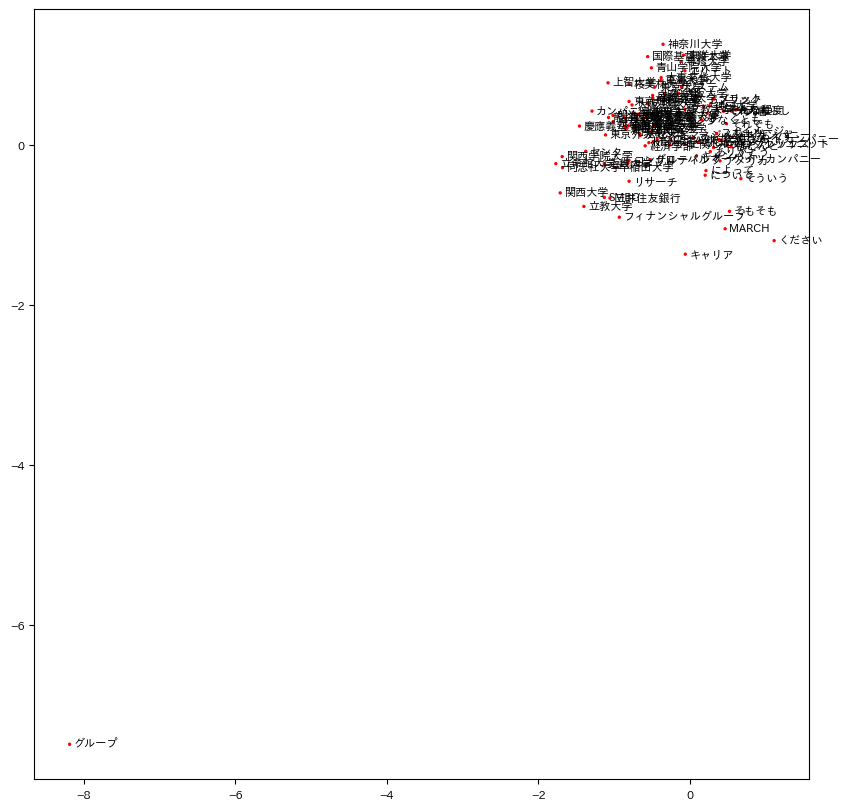

In [84]:
fig = make_plot(model, pca=(0,1), num = 100, min_word_len = 4, font_size=8)

### 5.3 プロットの実行